In [1]:
#!pip install -U numpy -q
#!pip install tensorflow==2.4.1 -q

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import wandb, os

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wab_key = user_secrets.get_secret("wab_key")

os.environ['WANDB_API_KEY'] = wab_key
run = wandb.init(project='tpu_test')

2022-08-06 15:46:55.913908: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-08-06 15:46:55.914053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
wandb: Currently logged in as: tiewa_enguin (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-08-06 15:47:04.303146: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-08-06 15:47:04.303726: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do n

In [3]:
#tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")

BATCH_SIZE = 64
#BATCH_SIZE = 8

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.MirroredStrategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-08-06 15:47:09.199774: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-06 15:47:09.202641: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-08-06 15:47:09.202715: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-06 15:47:09.202758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e218cac88245): /proc/driver/nvidia/version does not exist
2022-08-06 15:47:09.208078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [5]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-08-06 15:47:15.724140: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-08-06 15:47:15.815143: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [6]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

augmentations = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(dtype='float32'),
    layers.experimental.preprocessing.RandomZoom(0.1, 0.1, dtype='float32'),
    layers.experimental.preprocessing.RandomRotation(factor=0.1, dtype='float32'),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, dtype='float32'),
])

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [7]:
def load_dataset(filenames, train=True):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    if train:
        dataset = dataset.map(augmentations, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

Let's load in our datasets.

In [8]:
monet_ds = load_dataset(MONET_FILENAMES)
photo_ds = load_dataset(PHOTO_FILENAMES)
photo_ds_val = tf.data.TFRecordDataset(PHOTO_FILENAMES, num_parallel_reads=AUTOTUNE).map(read_tfrecord, num_parallel_calls=AUTOTUNE)

In [9]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's  visualize a photo example and a Monet example.

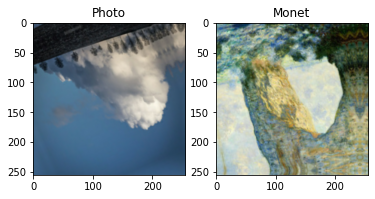

In [10]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [11]:
class CVE(layers.Conv2D):
    def __init__(self, *args, weight_std=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.kernel_initializer = tf.keras.initializers.RandomNormal(stddev=1.0)
        self.weight_std = weight_std
        
    def call(self, x):
        kernel, bias = self.weights
        k, k, i, o = kernel.shape
        fan_in = (k*k*i)**(-0.5)
        
        if self.weight_std:
            mean = tf.reduce_mean(kernel, axis=[1, 2, 3], keepdims=True)
            std = tf.math.reduce_std(kernel, axis=[1, 2, 3], keepdims=True)
            kernel = (kernel - mean) / std
            
        x = tf.nn.conv2d(x, kernel * fan_in, strides=[1,1,1,1], padding=self.padding.upper())
        x = tf.nn.bias_add(x, bias)
        return x

class ResBlock(layers.Layer):
    def __init__(self, nc, num_blocks=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.nc = nc
        self.num_blocks = num_blocks
        self.convs = []
        for _ in range(num_blocks):
            self.convs.append(CVE(nc, 3, padding='same'))
        self.res_gain = tf.Variable(0.0, trainable=True)
    
    def call(self, inp):
        x = inp
        for conv in self.convs:
            x = tf.nn.leaky_relu(conv(x))
        
        res_gain = tf.cast(self.res_gain, x.dtype)
        denorm_gain = tf.math.rsqrt(1 + res_gain ** 2)
        return denorm_gain * (inp + res_gain*x)
    
    def get_config(self):
        cfg = super().get_config()
        cfg['nc'] = self.nc
        cfg['num_blocks'] = self.num_blocks
        return cfg

In [12]:
class DiffUS(tf.keras.layers.Layer):
    def __init__(self, up=2, down=1, pad0=2, pad1=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.up = up
        self.down = down
            
        self._get_kernel()
    
    def _get_kernel(self):
        k = np.array([1, 3, 3, 1])
        k = k / np.sum(k)
        k = np.outer(k, k)
        k *= self.up ** 2
        
        self.w = tf.convert_to_tensor(k[:, :, np.newaxis, np.newaxis], dtype='float32')
        
    def call(self, inputs):
        N, H, W, C = inputs.shape
        
        x = inputs
        # Upsample (insert zeros).
        if self.up != 1:
            x = tf.reshape(x, [-1, H, 1, W, 1, C])
            x = tf.pad(x, [[0, 0], [0, 0], [0, self.up - 1], [0, 0], [0, self.up - 1], [0, 0]])
            x = tf.reshape(x, [-1, H * self.up, W * self.up, C])

        x = tf.transpose(x, (0, 3, 1, 2))

        # Convolve with filter.
        x = tf.reshape(x, [-1, 1, H * self.up, W * self.up])
        x = x[:, 0, :, :, None]
        x = tf.nn.conv2d(x, tf.cast(self.w, x.dtype), strides=[1,self.down,self.down,1], padding='SAME')
        x = tf.reshape(x, [-1, C, H * self.up // self.down, W * self.up // self.down])
        x = tf.transpose(x, (0, 2, 3, 1))
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'up': self.up,
            'down': self.down,
                      })
        return config

In [13]:
OUTPUT_CHANNELS = 3

def downsample(x, filters):
    x = CVE(filters, 1)(x)
    x = ResBlock(filters)(x)
    x = ResBlock(filters)(x)
    x = DiffUS(up=1, down=2)(x)
    return x

def upsample(x, filters):
    x = DiffUS()(x)
    x = CVE(filters, 1)(x)
    x = ResBlock(filters)(x)
    x = ResBlock(filters)(x)
    return x

In [14]:
def Generator(base_nc=32, downs=4):
    inputs = layers.Input(shape=[256,256,3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in range(downs):
        nc = base_nc * (2 ** down)
        x = downsample(x, nc)
        skips.insert(0, x)
    
    bottleneck_nc = base_nc * (2 ** downs)
    bottleneck = [CVE(bottleneck_nc, 1), *[ResBlock(bottleneck_nc) for _ in range(2)], CVE(bottleneck_nc//2, 1)]
    for block in bottleneck:
        x = block(x)

    # Upsampling and establishing the skip connections
    for idx, skip in enumerate(skips):
        nc = bottleneck_nc // 2 / (2 ** idx)
        x = layers.Concatenate()([x, skip])
        x = upsample(x, nc)
        x = CVE(max(nc//2, base_nc), 1)(x)
        
    x = layers.Concatenate()([x, inputs])
    x = CVE(OUTPUT_CHANNELS, 1, weight_std=False, dtype='float32')(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [15]:
def Discriminator(base_nc=32, downs=4, max_nc=1024):
    inputs = layers.Input(shape=[256,256,3])
    x = inputs

    # Downsampling through the model
    for down in range(downs):
        nc = min(max_nc, base_nc * (2 ** down))
        x = downsample(x, nc)
    nc = min(max_nc, base_nc * (2 ** downs))
    x = CVE(nc, 1)(x)
    x = ResBlock(nc)(x)
    x = ResBlock(nc)(x)
    #x = CVE(1, 1, weight_std=False, dtype='float32')(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    x = tf.cast(x, 'float32')

    return keras.Model(inputs=inputs, outputs=x)

# VGG

In [16]:
def build_vgg():
    cutoffLayer = -2
    vgg = tf.keras.applications.VGG16(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet")
    vgg.outputs = tf.cast(vgg.layers[cutoffLayer].output, 'float32')
    inputLayer = vgg.layers[0].output

    return keras.Model(inputLayer, vgg.outputs)

In [17]:
with strategy.scope():
    gen = Generator() # transforms photos to Monet-esque paintings
    disc = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    vgg = build_vgg()

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
gen.summary()
disc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
cve (CVE)                       (None, 256, 256, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
res_block (ResBlock)            (None, 256, 256, 32) 9249        cve[0][0]                        
__________________________________________________________________________________________________
res_block_1 (ResBlock)          (None, 256, 256, 32) 9249        res_block[0][0]                  
______________________________________________________________________________________________

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

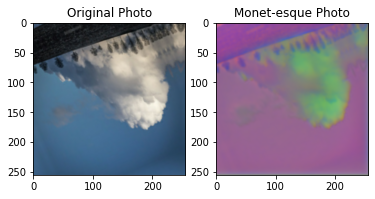

In [19]:
to_monet = gen(example_photo[:1])
to_monet = to_monet.numpy()

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# GAN

In [20]:
class GAN(keras.Model):
    def __init__(self, gen, disc, vgg):
        super().__init__()
        self.gen = gen
        self.disc = disc
        self.vgg = vgg
        self.ema_gen = tf.keras.models.clone_model(self.gen)
        for weight, ema_weight in zip(self.gen.weights, self.ema_gen.weights):
            ema_weight.assign(weight)
    
    def disc_loss_fn(self, real_preds, fake_preds):
        real_loss = tf.nn.softplus(-real_preds) # -log(sigmoid(real_scores_out))
        generated_loss = tf.nn.softplus(fake_preds) # log(sigmoid(fake_scores_out))
        real_loss, generated_loss = tf.reduce_mean(real_loss), tf.reduce_mean(generated_loss)
        return real_loss, generated_loss
    
    def gen_loss_fn(self, fake_preds):
        adv_loss = tf.reduce_mean(tf.nn.softplus(-fake_preds)) # -log(sigmoid(fake_scores_out))
        return adv_loss
    
    '''def gen_loss_fn(self, vgg_x, vgg_gen, fake_preds, vgg_weight=1.0, adv_weight=1.0):
        #vgg_loss = tf.reduce_mean(tf.square(tf.cast((vgg_x - vgg_gen)/255., 'float32')))
        vgg_loss = tf.reduce_mean(tf.square((vgg_x - vgg_gen)/255.))
        adv_loss = tf.reduce_mean(tf.nn.softplus(-fake_preds)) # -log(sigmoid(fake_scores_out))
        return vgg_weight*vgg_loss, adv_weight*adv_loss
    
    def rel_disc_loss_fn(self, real_preds, fake_preds):
        real_loss = tf.reduce_mean(tf.nn.softplus(tf.reduce_mean(fake_preds) - real_preds))
        fake_loss = tf.reduce_mean(tf.nn.softplus(fake_preds - tf.reduce_mean(real_preds)))
        return real_loss, fake_loss
    
    def rel_gen_loss_fn(self, vgg_x, vgg_gen, real_preds, fake_preds, vgg_weight=0.0, adv_weight=1.0):
        #vgg_loss = tf.reduce_mean(tf.square(tf.cast((vgg_x - vgg_gen)/255., 'float32')))
        vgg_loss = tf.reduce_mean(tf.square((vgg_x - vgg_gen)/255.))
        real_loss = tf.nn.softplus(tf.reduce_mean(real_preds) - fake_preds)
        fake_loss = tf.nn.softplus(real_preds - tf.reduce_mean(fake_preds))
        adv_loss = tf.reduce_mean(real_loss + fake_loss)
        return vgg_weight*vgg_loss, adv_weight*adv_loss'''
        
    def compile(self, gen_opt, disc_opt, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.gen_opt = gen_opt
        self.disc_opt = disc_opt
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        real_preds = self.disc(real_monet)
        fake_preds = self.disc(self.gen(real_photo))
        disc_loss_real, disc_loss_fake = self.disc_loss_fn(real_preds, fake_preds)
        r1_grad = tf.gradients(tf.reduce_sum(real_preds), [real_monet])[0]
        r1_penalty = tf.reduce_mean(tf.reduce_sum(tf.square(r1_grad), axis=[1,2,3]))
        disc_loss = disc_loss_real + disc_loss_fake + r1_penalty
        d_grad = tf.gradients(disc_loss, self.disc.trainable_variables)
        self.disc_opt.apply_gradients(zip(d_grad, self.disc.trainable_variables))
        
        generated = self.gen(real_photo)
        fake_preds = self.disc(generated)
        adv_loss = self.gen_loss_fn(fake_preds)
        #vgg_x = self.vgg(keras.applications.vgg16.preprocess_input(real_photo*127.5+127.5))
        #vgg_gen = self.vgg(keras.applications.vgg16.preprocess_input(generated*127.5+127.5))
        #vgg_loss = 1e-3 * tf.reduce_mean(tf.square((vgg_x - vgg_gen)))
        gen_loss = adv_loss #+ vgg_loss
        g_grad = tf.gradients(gen_loss, self.gen.trainable_variables)
        self.gen_opt.apply_gradients(zip(g_grad, self.gen.trainable_variables))
        
        for weight, ema_weight in zip(self.gen.weights, self.ema_gen.weights):
            ema_weight.assign(0.999 * ema_weight + 0.001 * weight)
        
        return {
            #'vgg_loss': vgg_loss,
            'adv_loss': adv_loss,
            'disc_loss_real': disc_loss_real,
            'disc_loss_fake': disc_loss_fake,
            'r1_penalty': r1_penalty,
        }

In [21]:
class SaveCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        fig, ax = plt.subplots(3, 5, figsize=(30, 12))
        for i, img in enumerate(photo_ds_val.batch(1).take(5)):
            img = img[:1]
            g_pred = gan.gen(img, training=False)[0].numpy()
            g_ema_pred = gan.ema_gen(img, training=False)[0].numpy()
            
            prediction = np.clip(g_pred * 127.5 + 127.5, 0, 255).astype(np.uint8)
            prediction_ema = np.clip(g_ema_pred * 127.5 + 127.5, 0, 255).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[0, i].imshow(img)
            ax[0, i].set_title("Input Photo")
            ax[0, i].axis("off")
            ax[1, i].imshow(prediction)
            ax[1, i].set_title("Monet-esque")
            ax[1, i].axis("off")
            ax[2, i].imshow(prediction_ema)
            ax[2, i].set_title("Monet-esque (EMA generator)")
            ax[2, i].axis("off")
        wandb.log({'preds': wandb.Image(fig)})
        plt.clf()

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [22]:
with strategy.scope():
    gen_opt = tf.keras.optimizers.Adam(5e-4, beta_1=0.0, beta_2=0.99)
    disc_opt = tf.keras.optimizers.Adam(5e-4, beta_1=0.0, beta_2=0.99)

In [23]:
with strategy.scope():
    gan = GAN(gen, disc, vgg)
    gan.compile(gen_opt, disc_opt)

In [ ]:
gan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100,
    steps_per_epoch=1024,
    callbacks=[SaveCallback()] #, wandb.keras.WandbCallback()]
)

Epoch 1/100


2022-08-06 15:47:39.975016: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 15592, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1659800859.971631675","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 15592, Output num: 0","grpc_status":3}


1024/1024 [==============================] - 521s 446ms/step - adv_loss: 1.2491 - disc_loss_real: 0.6803 - disc_loss_fake: 0.6811 - r1_penalty: 0.0102
Epoch 2/100


2022-08-06 15:56:20.586506: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 35741, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1659801380.586451247","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 35741, Output num: 0","grpc_status":3}


1024/1024 [==============================] - 461s 446ms/step - adv_loss: 1.3628 - disc_loss_real: 0.5519 - disc_loss_fake: 0.5495 - r1_penalty: 0.0270
Epoch 3/100


2022-08-06 16:04:01.945680: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 50679, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1659801841.945559004","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 50679, Output num: 0","grpc_status":3}


 201/1024 [====>.........................] - ETA: 6:07 - adv_loss: 1.4072 - disc_loss_real: 0.5314 - disc_loss_fake: 0.5464 - r1_penalty: 0.0530

# Visualize our Monet-esque photos

In [ ]:
_, ax = plt.subplots(2, 5, figsize=(30, 12))
for i, img in enumerate(photo_ds_val.batch(1).take(5)):
    img = img[:1]
    gz = gan.gen(img, training=False)
    prediction = gz[0].numpy()
    prediction = np.clip(prediction * 127.5 + 127.5, 0, 255).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
plt.show()

# Create submission file

In [ ]:
import PIL
! mkdir /kaggle/working/images

In [ ]:
i = 1
from tqdm.notebook import tqdm

for batch in tqdm(photo_ds_val.batch(128)):
    preds = gen.predict(batch)
    preds = np.clip(preds * 127.5 + 127.5, 0, 255).astype(np.uint8)
    for pred in preds:
        im = PIL.Image.fromarray(pred)
        im.save("/kaggle/working/images/" + str(i) + ".jpg")
        i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")